# Multiple input single output model


In [1]:
from src.loaders.data_loader import load_train_data
from src.loaders.window_generator import WindowGenerator
from src.preprocessors.preprocessors import split_train_valid_test
from src.preprocessors.preprocessors import apply_standard_scale
from src.model.multiple.dense import MultipleDense
from src.preprocessors.add_columns import add_sin_cos

df = load_train_data()
df = add_sin_cos(df, "Hour")
n = len(df)
train_df, valid_df, test_df = split_train_valid_test(df, [0.7, 0.2, 0.1])
scaled_train_df, scaled_valid_df, scaled_test_df = apply_standard_scale(train_df, valid_df, test_df)


ratio should be 3 length list, example: [0.6, 0.3, 0.1]
sum of ration should be 1, example: [0.7, 0.2, 0.1]
shape of train, valid, test: (36792, 11), (10511, 11), (5257, 11)


In [2]:
from src.trainers import compile_and_fit_with_pinball_loss

valid_performance = {}
performance = {}

conv_window_scaled = WindowGenerator(
    scaled_train_df,
    scaled_valid_df,
    scaled_test_df,
    input_width=48,
    label_width=1,
    shift=1,
    label_columns=["TARGET"]
)
scaled_multi_dense_model = MultipleDense()
history = compile_and_fit_with_pinball_loss(scaled_multi_dense_model, conv_window_scaled, 0.1)

valid_performance["Multi step dense"] = scaled_multi_dense_model.evaluate(conv_window_scaled.valid)
performance["Multi step dense"] = scaled_multi_dense_model.evaluate(conv_window_scaled.test, verbose=0)


Epoch 1/1000
1149/1149 [==============================] - 6s 5ms/step - loss: 0.0683 - mean_absolute_error: 0.4997 - mean_squared_error: 0.5346 - _pinball_loss: 0.0683 - val_loss: 0.0530 - val_mean_absolute_error: 0.4202 - val_mean_squared_error: 0.4690 - val__pinball_loss: 0.0530

In [3]:
scaled_pred_y = scaled_multi_dense_model.predict(conv_window_scaled.test_for_predict)

In [4]:
_mean = train_df["TARGET"].mean()
_std = train_df["TARGET"].std()
pred_y = (scaled_pred_y * _std + _mean).reshape(-1)

In [5]:
import numpy as np
true_y = test_df[48:]["TARGET"].values

np.mean(np.maximum(0.1 * (true_y - pred_y), (0.1 - 1) * (true_y - pred_y)))

0.7641802384404541

In [6]:
from src.preprocessors.preprocessors import inverse_standard_scale

scaled_pred_y = scaled_multi_dense_model.predict(conv_window_scaled.test_for_predict)
pred_y = inverse_standard_scale(train_df["TARGET"], scaled_pred_y)
np.mean(np.maximum(0.1 * (true_y - pred_y), (0.1 - 1) * (true_y - pred_y)))

0.7641802384404541

In [9]:
from src.model.multiple.convolution import SimpleConv

simple_convolution = SimpleConv()
history = compile_and_fit_with_pinball_loss(simple_convolution, conv_window_scaled, 0.1)

valid_performance["Conv"] = simple_convolution.evaluate(conv_window_scaled.valid)
performance["Conv"] = simple_convolution.evaluate(conv_window_scaled.test, verbose=0)

Epoch 1/1000
1149/1149 [==============================] - 7s 5ms/step - loss: 0.0869 - mean_absolute_error: 0.4612 - mean_squared_error: 0.4710 - _pinball_loss: 0.0869 - val_loss: 0.0521 - val_mean_absolute_error: 0.3208 - val_mean_squared_error: 0.2685 - val__pinball_loss: 0.0521

In [10]:
import src.model
import importlib
from src.model.loss import pinball_loss_numpy
importlib.reload(src.model)
scaled_pred_y = simple_convolution.predict(conv_window_scaled.test_for_predict)
pred_y = inverse_standard_scale(train_df["TARGET"], scaled_pred_y)
pinball_loss_numpy(true_y, pred_y, 0.1)


0.5006006562051574

3
3


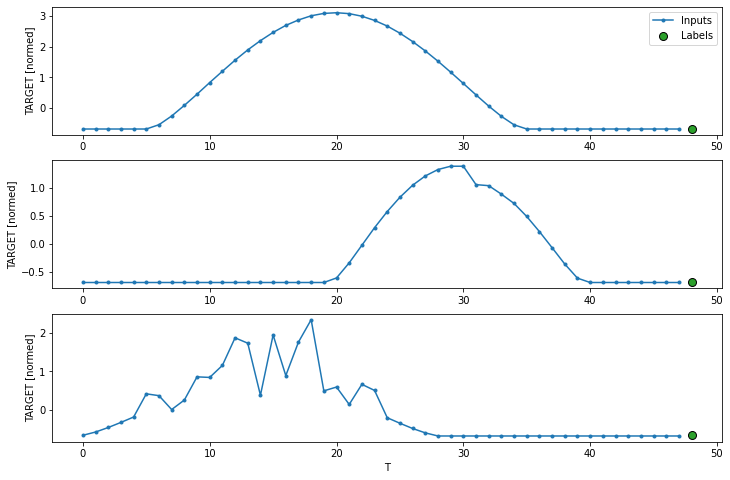

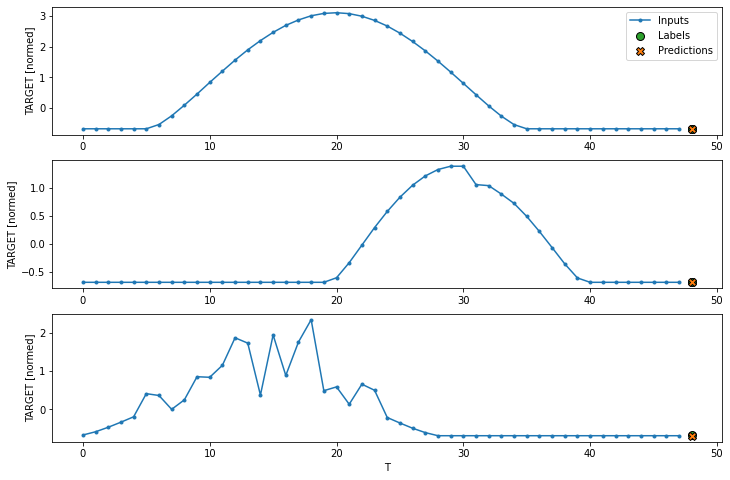

In [11]:
import src.loaders
importlib.reload(src.loaders)

conv_window_scaled.plot()
conv_window_scaled.plot(simple_convolution)

In [12]:
CONV_WIDTH = 48
LABEL_WIDTH = 48
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    scaled_train_df,
    scaled_valid_df,
    scaled_test_df,
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=["TARGET"]
)

wide_conv_window


            Total window size: 96
            Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
            Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
            Label column name(s): ['TARGET']
        

3


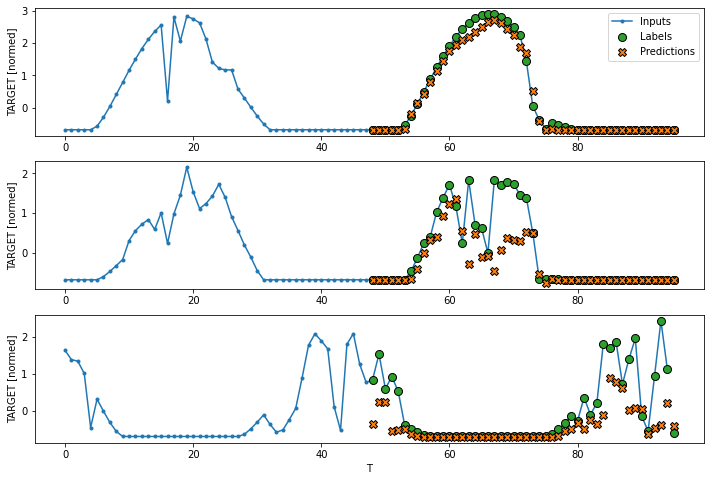

In [13]:
wide_conv_window.plot(simple_convolution)

In [14]:
scaled_pred_y = simple_convolution.predict(wide_conv_window.test_for_predict)
pred_y = inverse_standard_scale(train_df["TARGET"], scaled_pred_y)
pinball_loss_numpy(true_y[47:], pred_y.reshape(-1, 48, 1)[:, -1, :].reshape(-1), 0.1)

0.49922123127446627

In [15]:
importlib.reload(src.loaders.data_loader)
from src.loaders.data_loader import load_test_data
real_test = load_test_data()


In [16]:
real_test_sin_cos_added = add_sin_cos(real_test, "Hour")
_, scaled_real_test, _ = apply_standard_scale(train_df, real_test_sin_cos_added, real_test_sin_cos_added)

In [17]:
scaled_real_test = scaled_real_test.values.reshape(81, -1, 11)[:, -INPUT_WIDTH:, :]
scaled_y_pred = simple_convolution.predict(scaled_real_test)

In [18]:
scaled_y_pred.shape

(81, 48, 1)

In [22]:
scaled_y_pred[0]

array([[-0.69414634],
       [-0.6908962 ],
       [-0.6902735 ],
       [-0.69136727],
       [-0.69264203],
       [-0.69243276],
       [-0.6931756 ],
       [-0.6920707 ],
       [-0.69469374],
       [-0.6963007 ],
       [-0.70088524],
       [-0.701663  ],
       [-0.70651925],
       [-0.70838785],
       [-0.6991608 ],
       [-0.6505707 ],
       [-0.6278853 ],
       [-0.5530434 ],
       [-0.5079325 ],
       [-0.4818077 ],
       [-0.45898348],
       [-0.41064587],
       [-0.2945789 ],
       [-0.42975557],
       [-0.40594396],
       [-0.42172113],
       [-0.404613  ],
       [-0.4404989 ],
       [-0.48874918],
       [-0.4859168 ],
       [-0.5654778 ],
       [-0.59560823],
       [-0.6869547 ],
       [-0.6894953 ],
       [-0.6886956 ],
       [-0.6885662 ],
       [-0.68919253],
       [-0.6894351 ],
       [-0.6895939 ],
       [-0.68993104],
       [-0.68976855],
       [-0.69056594],
       [-0.6898788 ],
       [-0.69158214],
       [-0.6917155 ],
       [-0